In [1]:
#Imports 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from keras import layers
from keras import models

import tensorflow_datasets as tfds

In [2]:
##################################### LOADING THE DATASET ######################################
ds, ds_info = tfds.load(
    'colorectal_histology',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incompleteGDO0R1/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [3]:
################################### PREPROCESSING THE DATA #####################################
#Normalizing the entire dataset
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds = ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

#Spliting data into testing, training and validation splits
ds_train = ds.take(int((5000) * 0.7))
ds_test = ds.skip(int((5000) * 0.7))
ds_val = ds_test.take(int((5000) * 0.15))
ds_test = ds_test.skip(int((5000) * 0.15))


#Cacheing, batching, prefetching
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(20)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.batch(20)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(20)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

#Data augmentation (random flipping and random rotation of data)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [4]:
##################################################### MODEL DEFINITION #################################################

model = models.Sequential()

#Data augmentation
model.add(data_augmentation)

#Convolutional base
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#Densely connected classifier 
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

In [5]:
#Compile and fit the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(
      learning_rate=0.001,
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

#Add callback for early stopping
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
    # callbacks=[callback],
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


175/175 [==============================] - 21s 51ms/step - loss: 1.2263 - sparse_categorical_accuracy: 0.4614 - val_loss: 0.9011 - val_sparse_categorical_accuracy: 0.5840
Epoch 2/100
175/175 [==============================] - 6s 33ms/step - loss: 0.9811 - sparse_categorical_accuracy: 0.5663 - val_loss: 0.7555 - val_sparse_categorical_accuracy: 0.6720
Epoch 3/100
175/175 [==============================] - 6s 32ms/step - loss: 0.8336 - sparse_categorical_accuracy: 0.6660 - val_loss: 0.7895 - val_sparse_categorical_accuracy: 0.7107
Epoch 4/100
175/175 [==============================] - 5s 31ms/step - loss: 0.7314 - sparse_categorical_accuracy: 0.7117 - val_loss: 0.7699 - val_sparse_categorical_accuracy: 0.7160
Epoch 5/100
175/175 [==============================] - 6s 36ms/step - loss: 0.7265 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.6407 - val_sparse_categorical_accuracy: 0.7333
Epoch 6/100
175/175 [==============================] - 5s 31ms/step - loss: 0.7165 - sparse_categoric

In [13]:
#Evaluate the model on test data
results = model.evaluate(ds_test)

38/38 [==============================] - 0s 9ms/step - loss: 0.3361 - sparse_categorical_accuracy: 0.9213


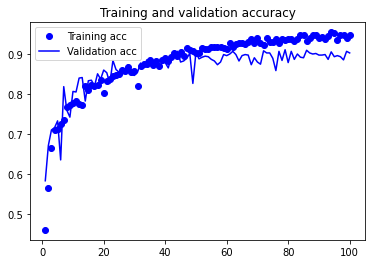

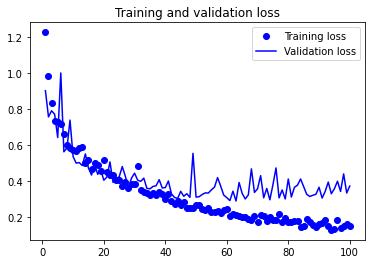



#################################################################
######################## EVALUATION RESULTS #####################
#################################################################


Evaluation loss: 0.33611756563186646, Evaluation accuracy: 0.9213333129882812


In [21]:
#Plotting the results of the training
import matplotlib.pyplot as plt

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Evaluate the model
print("")
print("")

print("#################################################################")
print("######################## EVALUATION RESULTS #####################")
print("#################################################################")

print("")
print("")
print('Evaluation loss: {}, Evaluation accuracy: {}'.format(results[0], results[1]))